In [1]:
from pathlib import Path

from pysr import PySRRegressor

# other imports after pysr since it has to be before torch?
from jaxtyping import Float
import numpy as np
from zanj import ZANJ
import sympy as sp

from maze_dataset import MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.benchmark.config_sweep import (
    SweepResult,
    full_percolation_analysis,
    dataset_success_fraction,
    plot_grouped,
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# magic auto-reload
%load_ext autoreload
%autoreload

tqdm_allowed_kwargs = {'delay', 'colour', 'gui', 'smoothing', 'nrows', 'desc', 'miniters', 'unit_scale', 'dynamic_ncols', 'file', 'position', 'ncols', 'iterable', 'ascii', 'write_bytes', 'unit_divisor', 'disable', 'unit', 'postfix', 'initial', 'bar_format', 'leave', 'total', 'maxinterval', 'lock_args', 'mininterval', 'self'}
mapped_kwargs = {'total': 3, 'desc': 'Processing 3 items'}


Processing 3 items: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


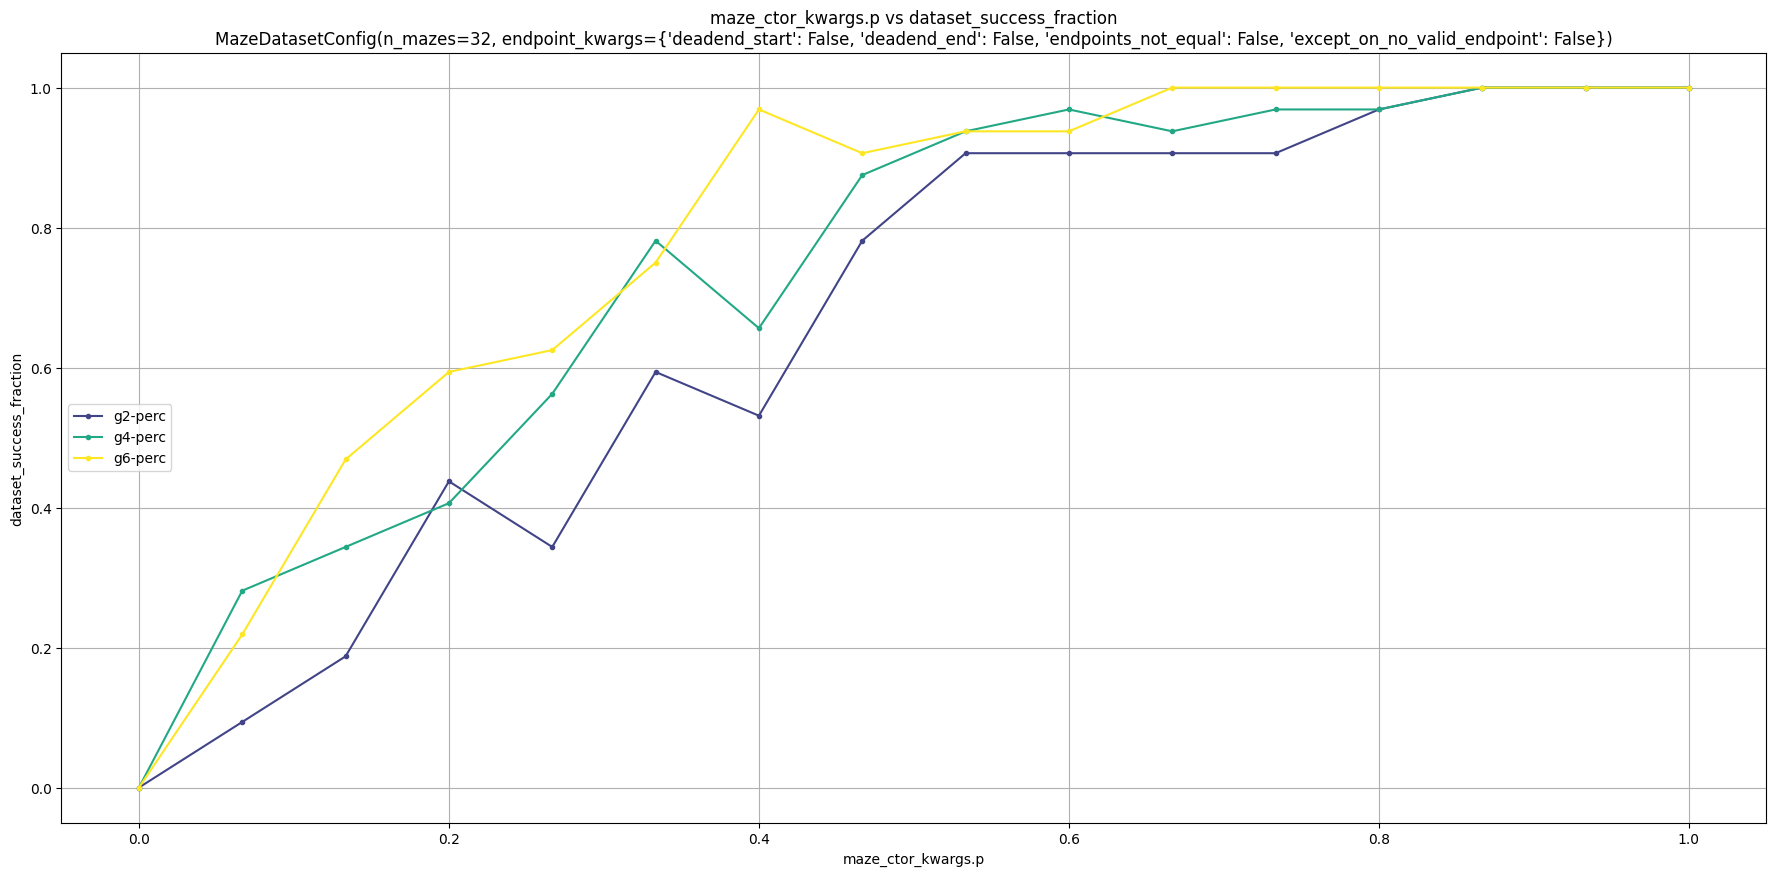

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [3]:
# Run the analysis
results: SweepResult = SweepResult.analyze(
    configs=[
        MazeDatasetConfig(
            name=f"g{grid_n}-perc",
            grid_n=grid_n,
            n_mazes=32,
            maze_ctor=LatticeMazeGenerators.gen_percolation,
            maze_ctor_kwargs=dict(),
            endpoint_kwargs=dict(
                deadend_start=False,
                deadend_end=False,
                endpoints_not_equal=False,
                except_on_no_valid_endpoint=False,
            ),
        )
        for grid_n in [2, 4, 6]
    ],
    param_values=np.linspace(0.0, 1.0, 16).tolist(),
    param_key="maze_ctor_kwargs.p",
    analyze_func=dataset_success_fraction,
    parallel=False,
)

# Plot results
results.plot(save_path=None, cfg_keys=["n_mazes", "endpoint_kwargs"])

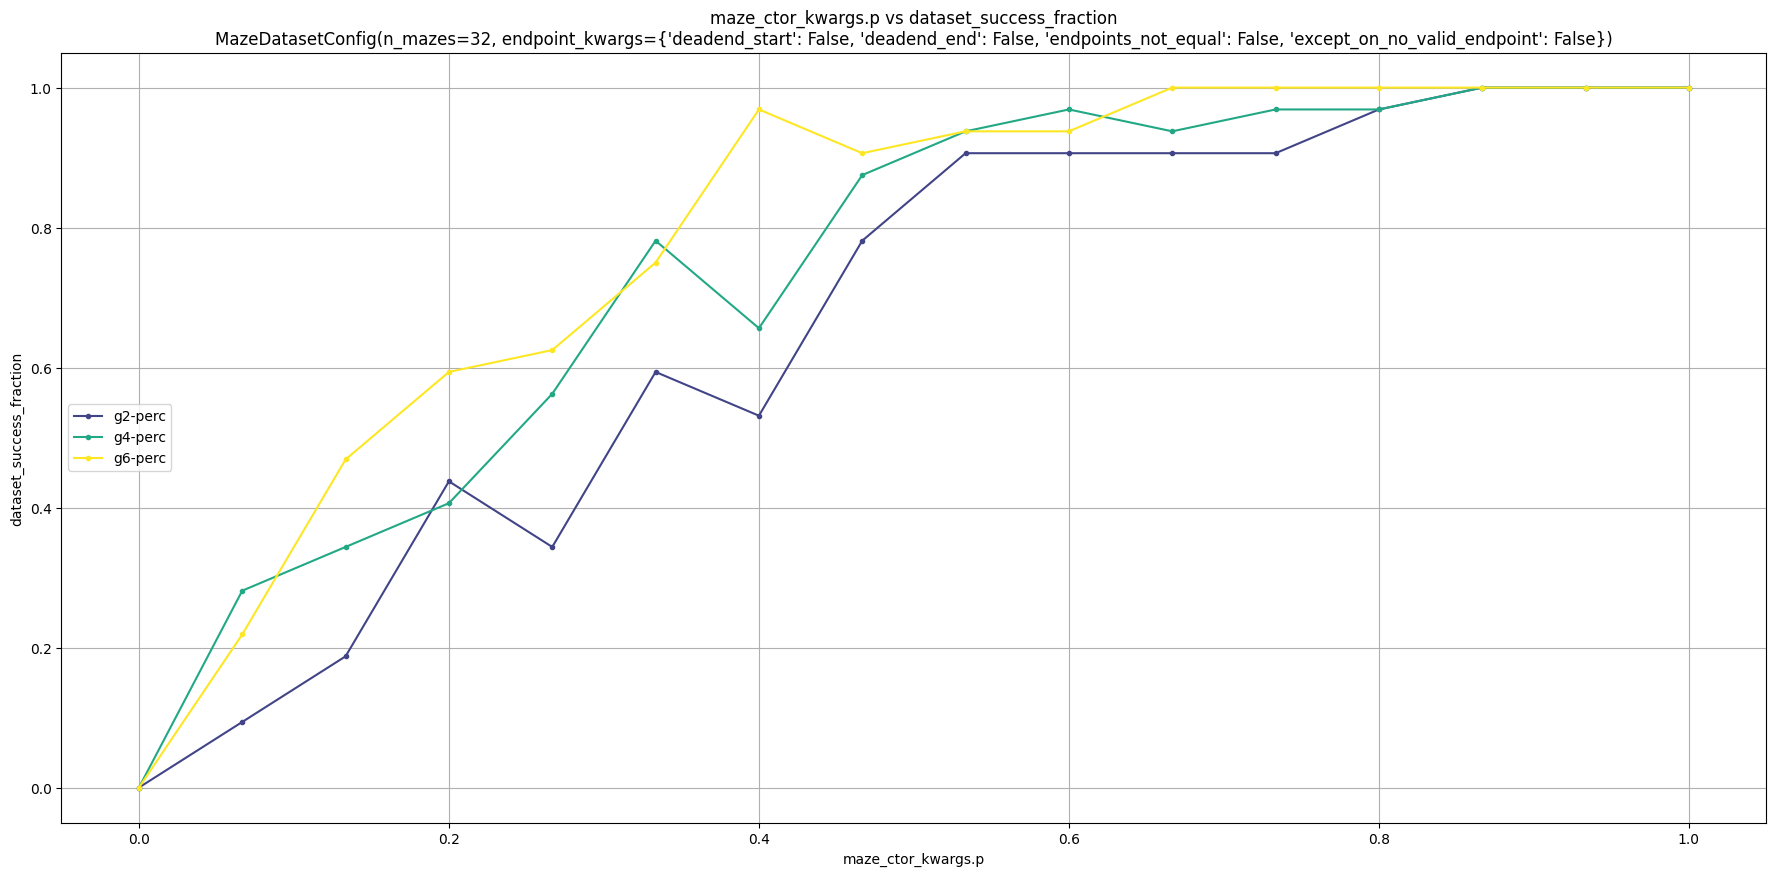

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [4]:
path = Path("../tests/_temp/dataset_frac_sweep/results_small.zanj")
results.save(path)
ZANJ().read(path).plot(cfg_keys=["n_mazes", "endpoint_kwargs"])

In [5]:
results_full: SweepResult = full_percolation_analysis(
    n_mazes=16,
    p_val_count=16,
    grid_sizes=[2, 4, 6],
    parallel=False,
)

tqdm_allowed_kwargs = {'delay', 'colour', 'gui', 'smoothing', 'nrows', 'desc', 'miniters', 'unit_scale', 'dynamic_ncols', 'file', 'position', 'ncols', 'iterable', 'ascii', 'write_bytes', 'unit_divisor', 'disable', 'unit', 'postfix', 'initial', 'bar_format', 'leave', 'total', 'maxinterval', 'lock_args', 'mininterval', 'self'}
mapped_kwargs = {'total': 18, 'desc': 'Processing 18 items'}


Processing 18 items: 100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


Saving results to ../docs/benchmarks/percolation_fractions/result-n16-c18-p16.zanj


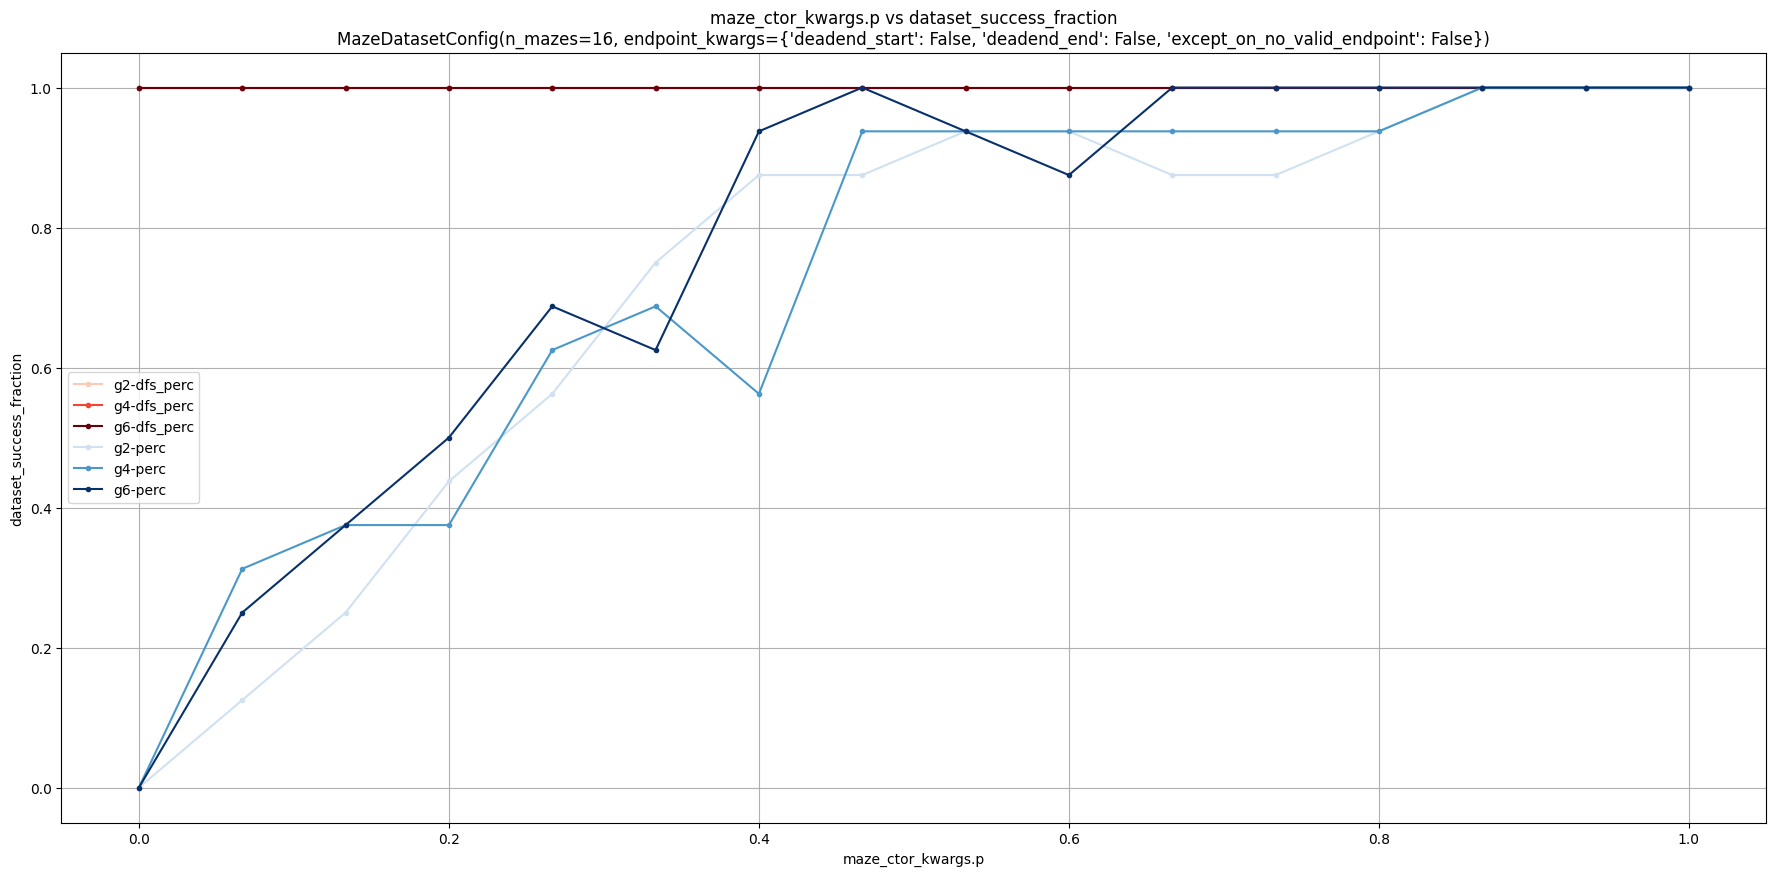

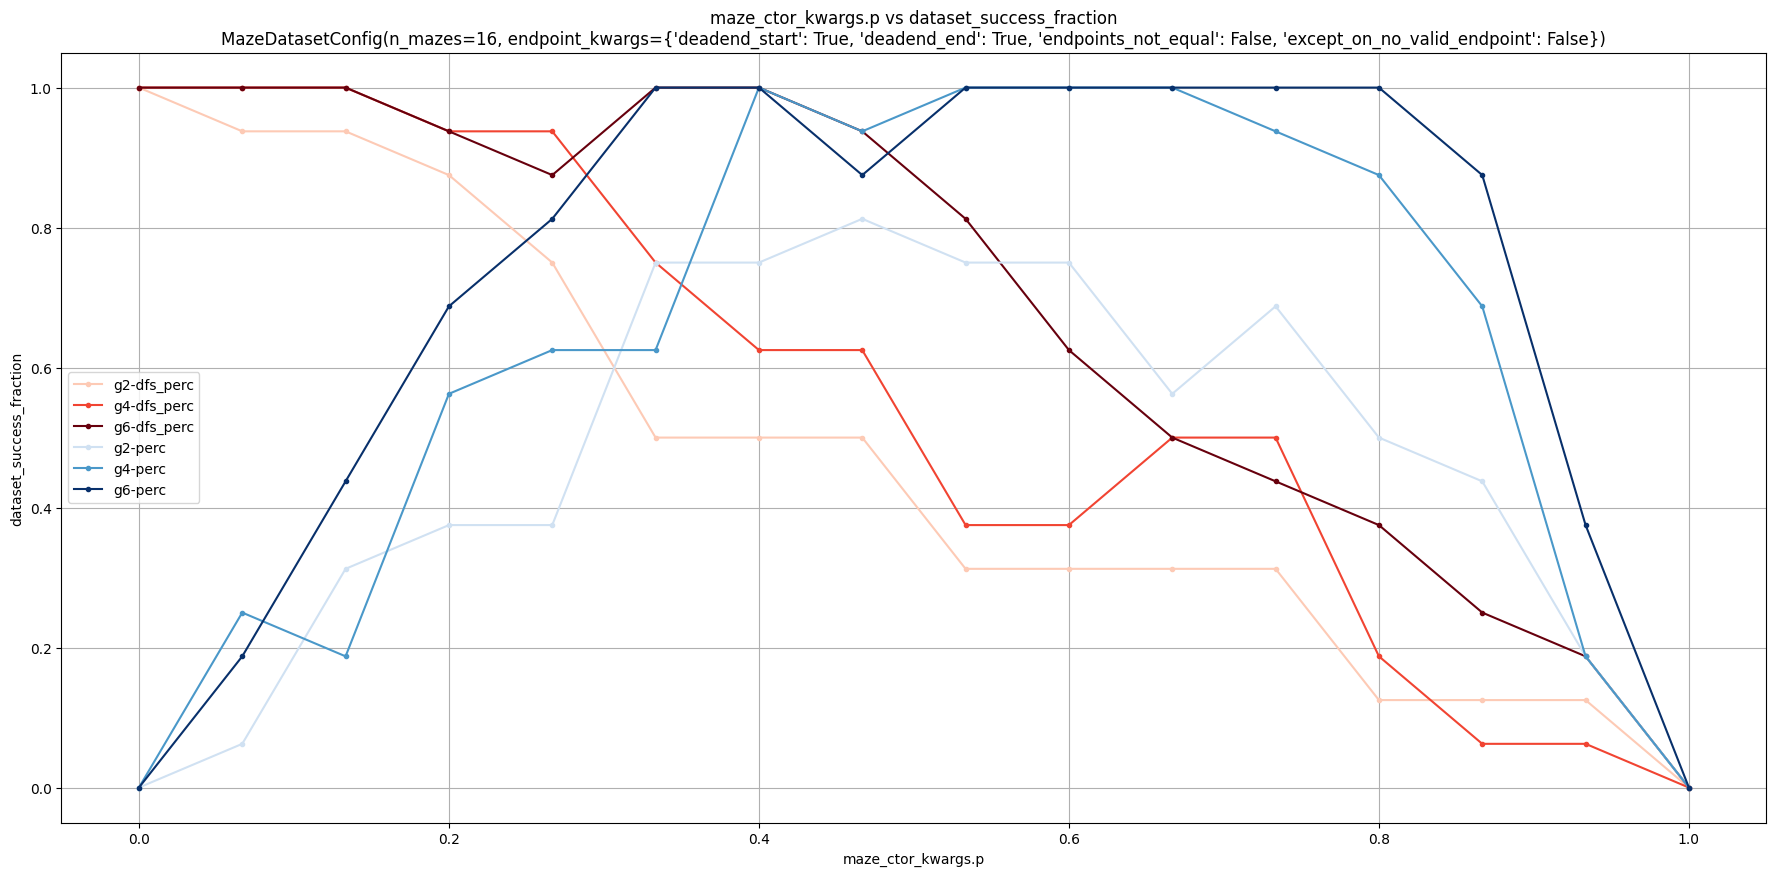

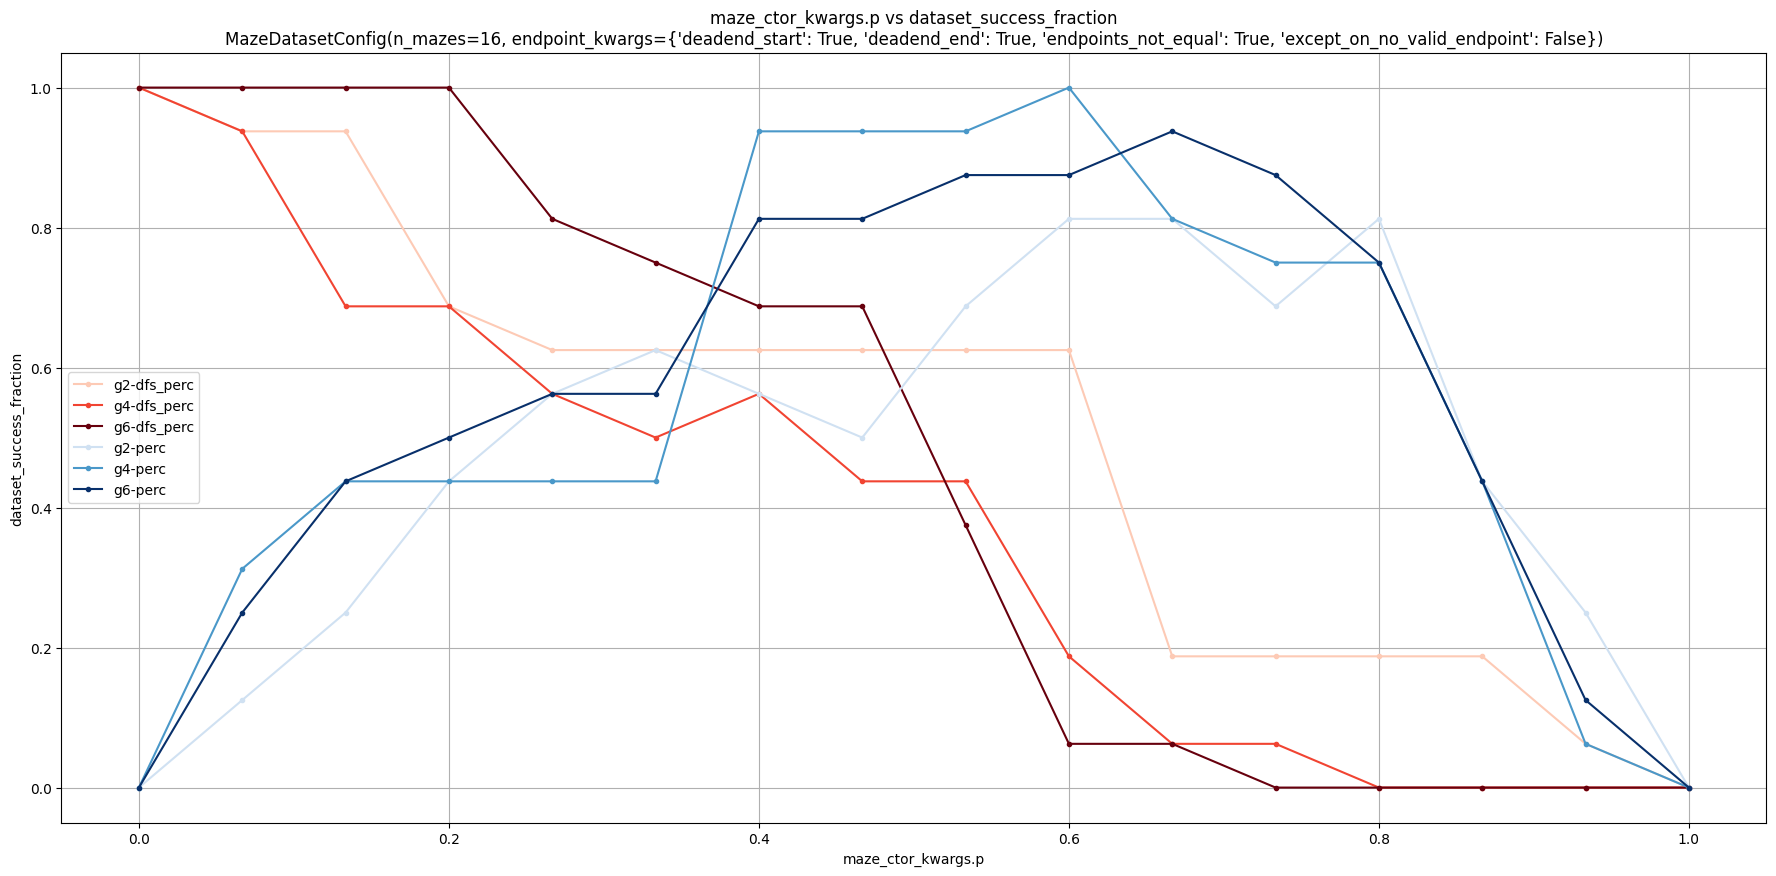

In [6]:
plot_grouped(results_full)

In [7]:
def extract_training_data(
    sweep_result: SweepResult,
) -> tuple[Float[np.ndarray, "num_rows 5"], Float[np.ndarray, " num_rows"]]:
    """Extract data (X, y) from a SweepResult.

    # Parameters:
     - `sweep_result : SweepResult`
        The sweep result holding configs and success arrays.

    # Returns:
     - `X : Float[np.ndarray, "num_rows 5"]`
        Stacked [p, grid_n, deadends, endpoints_not_equal, generator_func] for each config & param-value
     - `y : Float[np.ndarray, "num_rows"]`
        The corresponding success rate
    """
    X_list: list[list[float]] = []
    y_list: list[float] = []
    for cfg in sweep_result.configs:
        # success_arr is an array of success rates for param_values
        success_arr = sweep_result.result_values[cfg.to_fname()]
        for i, p in enumerate(sweep_result.param_values):
            # Temporarily override p in the config's array representation:
            arr = cfg._to_ps_array().copy()
            arr[0] = p  # index 0 is 'p'
            X_list.append(arr)
            y_list.append(success_arr[i])

    return np.array(X_list, dtype=np.float64), np.array(y_list, dtype=np.float64)

In [ ]:
DATA_PATH: str = "../docs/benchmarks/percolation_fractions/medium/result-n128-c42-p50.zanj"
# DATA_PATH: str = "../docs/benchmarks/percolation_fractions/small/result-n64-c30-p25.zanj"
# DATA_PATH: str = "../docs/benchmarks/percolation_fractions/test/result-n16-c12-p16.zanj"
RESULTS_LOADED: SweepResult = SweepResult.read(DATA_PATH)

# Convert to arrays
X, y = extract_training_data(RESULTS_LOADED)

print(f"training data extracted: {X.shape = }, {y.shape = }")

# Fit the PySR model
model = PySRRegressor(
    niterations=300,
    # Adjust operators as needed
    unary_operators=[
        "exp",
        "log",
        "square(x) = x^2",
        "cube(x) = x^3",
        "sigmoid(x) = 1/(1 + exp(-x))",
    ],
    extra_sympy_mappings={
        "square": lambda x: x**2,
        "cube": lambda x: x**3,
        "sigmoid": lambda x: 1 / (1 + sp.exp(-x)),
    },
    binary_operators=["+", "-", "*", "/"],
    # If you want advanced features, specify them here:
    # e.g. select_k_features=4, population_size=1000, etc.
	populations=50,
    progress=True,
    model_selection="best",
)
model.fit(X, y)

training data extracted: X.shape = (2100, 5), y.shape = (2100,)
Compiling Julia backend...


f:\KNC\maze-dataset\.venv\Lib\site-packages\pysr\sr.py:2780: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [ ]:
# Create a callable that predicts from MazeDatasetConfig
predict_fn = model.get_best()["lambda_format"]
print(f"Best PySR Equation: {model.get_best()['equation'] = }")
print(f"{predict_fn =}")


def predict_config(cfg: MazeDatasetConfig) -> float:
    arr = cfg._to_ps_array()
    result = predict_fn(arr)[0]
    return float(result)  # pass the array as separate args


# Example new config
test_config = MazeDatasetConfig(
    name="some_test",
    grid_n=16,
    n_mazes=100,
    maze_ctor=LatticeMazeGenerators.gen_percolation,
    maze_ctor_kwargs={"p": 0.3},
    endpoint_kwargs={
        "deadend_start": True,
        "deadend_end": True,
        "endpoints_not_equal": True,
        "except_on_no_valid_endpoint": False,
    },
)
predicted_rate = predict_config(test_config)
print("Best PySR Equation:", model.get_best()["equation"])
print("Predicted success rate for test_config:", predicted_rate)


plot_grouped(RESULTS_LOADED, predict_fn=predict_config)